In [ ]:
import pandas as pd
import numpy as np
import scipy.sparse
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:

dtype = {
    'SUPPLIER_ERP': 'str',
    'SUPPLIER_NBR': 'str',
    'SUPPLIER_ADDRESS_1': 'str',
    'SUPPLIER_CITY': 'str',
    'SUPPLIER_COUNTRY': 'str',
    'SUPPLIER_STATE': 'str',
    'SUPPLIER_TAXID': 'str',
    'SUPPLIER_ZIP_POSTAL_CDE':'str',
}

df = pd.read_csv('TBC Raw Supplier Master.csv', encoding='UTF-8-SIG', dtype=dtype)

df_shape = df.shape
print("DataFrame shape:",df_shape)

DataFrame shape: (6831, 10)


In [ ]:
# Custom TF-IDF vectorizer that boosts the TF-IDF scores of the words of interest


class CustomTfidfVectorizer(TfidfVectorizer):
    def __init__(self, keyword_list, boost_val, 
                 input='content', encoding='utf-8', decode_error='strict', 
                 strip_accents=None, lowercase=False, preprocessor=None, 
                 tokenizer=None, analyzer='word', stop_words=None, 
                 token_pattern=r"(?u)\b\w\w+\b", ngram_range=(1, 1), 
                 max_df=1.0, min_df=1, max_features=None, vocabulary=None, 
                 binary=False, dtype=np.int64, norm='l2', use_idf=True, 
                 smooth_idf=True, sublinear_tf=False):

        # Initialize our added parameters
        self.keyword_list = keyword_list
        self.boost_val = boost_val

        # Initialize TfidfVectorizer with passed parameters
        super().__init__(input=input, encoding=encoding, decode_error=decode_error, 
                         strip_accents=strip_accents, lowercase=lowercase, preprocessor=preprocessor, 
                         tokenizer=tokenizer, analyzer=analyzer, stop_words=stop_words, 
                         token_pattern=token_pattern, ngram_range=ngram_range, 
                         max_df=max_df, min_df=min_df, max_features=max_features, vocabulary=vocabulary, 
                         binary=binary, dtype=dtype, norm=norm, use_idf=use_idf, 
                         smooth_idf=smooth_idf, sublinear_tf=sublinear_tf)

def transform(self, raw_documents, copy=True):
    X = super(CustomTfidfVectorizer, self).transform(raw_documents, copy=copy)
    for word in self.keyword_list:
        if word in self.vocabulary_:
            X[:, self.vocabulary_[word]] *= self.boost_val
    return X



In [ ]:
# Keywords to emphasize clustering
keywords = ["SUBURBAN PROPANE", 
            ]

In [ ]:
# Create a custom TF-IDF vectorizer
vectorizer = CustomTfidfVectorizer(keyword_list=keywords, boost_val=5.0, stop_words="english")

# Fit the pipeline on the company names and compute the tfidf_matrix
tfidf_matrix = vectorizer.fit_transform(df["SUPPLIER_ERP"])

# Transform the keywords into the TF-IDF space
keywords_tfidf = vectorizer.transform(keywords)

# Create a KMeans clustering model.
n_clusters = 5500  # Adjust this as per your requirements.
kmeans = KMeans(n_clusters=n_clusters)

# Cluster the data
kmeans.fit(tfidf_matrix)

# Get cluster labels
labels = kmeans.labels_

# Add the cluster labels back to the main dataframe
df['label'] = labels

# Store cosine similarities to the centroid of each cluster
similarities_to_centroid = []
centroids = kmeans.cluster_centers_

for i, label in enumerate(labels):
    similarity = cosine_similarity(tfidf_matrix[i].reshape(1, -1), centroids[label].reshape(1, -1))[0][0]
    similarities_to_centroid.append(similarity)

df['similarity'] = similarities_to_centroid

d:\Users\diana.fernandez\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:2065: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'numpy.int64'> 'dtype' will be converted to np.float64.
  warnings.warn(
d:\Users\diana.fernandez\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
# Existing KMeans clustering part
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(tfidf_matrix)

# Inertia
total_inertia = kmeans.inertia_
print(f"Total Inertia: {total_inertia}")


d:\Users\diana.fernandez\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Total Inertia: 258.20285113084975


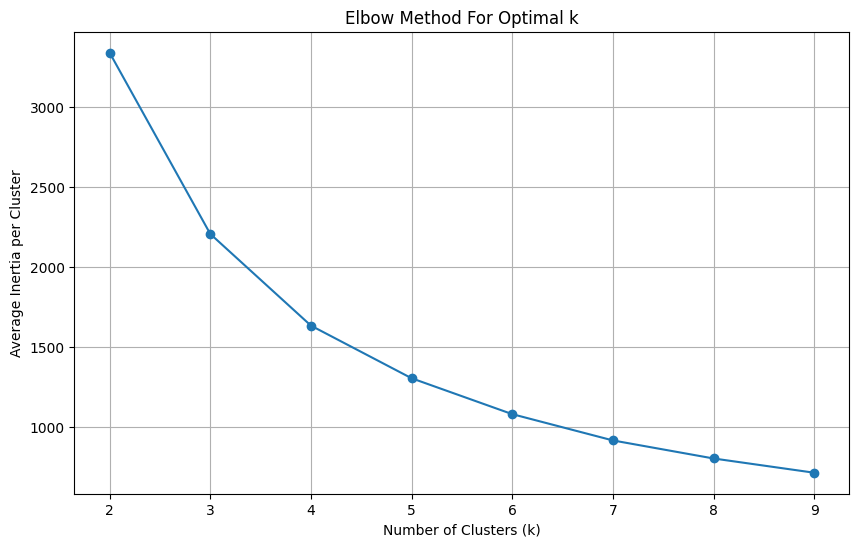

In [ ]:
import matplotlib.pyplot as plt

# Define range of k values to check
k_values = range(2, 10) 
inertias = []

# Iterating over different k values
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(tfidf_matrix)
    inertias.append(kmeans.inertia_ / k)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertias, '-o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Average Inertia per Cluster')
plt.title('Elbow Method For Optimal k')
plt.xticks(k_values)
plt.grid(True)
plt.show()


In [ ]:
# Find the representative name for each cluster centroid
representative_names = []
for center in centroids:
    # Check if centroid is close to a keyword vector
    keyword_similarities = cosine_similarity(center.reshape(1, -1), keywords_tfidf)
    max_keyword_similarity_index = keyword_similarities.argmax()
    
    # If the max similarity is above a certain threshold, use the keyword
    if keyword_similarities[0, max_keyword_similarity_index] > 0.75:  # Adjust the threshold as needed
        representative_name = keywords[max_keyword_similarity_index]
    else:
        # Find the closest supplier to the centroid
        supplier_similarities = cosine_similarity(center.reshape(1, -1), tfidf_matrix)
        representative_index = supplier_similarities.argmax()
        representative_name = df.iloc[representative_index]["SUPPLIER_ERP"]
    
    representative_names.append(representative_name)

In [ ]:
for center in centroids:
    # Check if centroid is close to a keyword vector
    keyword_similarities = cosine_similarity(center.reshape(1, -1), keywords_tfidf)
    max_keyword_similarity_index = keyword_similarities.argmax()
    
    # If the max similarity is above a certain threshold, use the keyword
    if keyword_similarities[0, max_keyword_similarity_index] > 0.75:  # Adjust the threshold as needed
        representative_name = keywords[max_keyword_similarity_index]
    else:
        # Find the closest supplier to the centroid
        supplier_similarities = cosine_similarity(center.reshape(1, -1), tfidf_matrix)
        representative_index = supplier_similarities.argmax()
        representative_name = df.iloc[representative_index]["SUPPLIER_ERP"]
    
    representative_names.append(representative_name)

# Map cluster labels to the representative names
cluster_to_name_map = {i: name for i, name in enumerate(representative_names)}

# Add a new column to your dataframe for the representative names of each cluster
df['normalized_name'] = df['label'].map(cluster_to_name_map)

In [ ]:
# Export the resulting table
df[['label', 
    'SUPPLIER_ERP', 
    'SUPPLIER_NBR',
    'SUPPLIER_ADDRESS_1',
    'SUPPLIER_CITY',
    'SUPPLIER_COUNTRY',
    'SUPPLIER_STATE',
    'SUPPLIER_TAXID',
    'SUPPLIER_ZIP_POSTAL_CDE', 
    'normalized_name', 
    'TOTAL_SPEND_USD', 
    'ROW_COUNT', 
    'similarity']].to_csv('TBC Clustered Supplier Master.csv', index=False)